# Tools & Libraries

In [4]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print(file_dir)
parent_dir = file_dir.parent
print(parent_dir)
sys.path.append(str(parent_dir))

C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython\stc
C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython


In [77]:
from pa_lib.job import request_job
from pa_lib.file import project_dir, load_bin
from pa_lib.data import desc_col
from pa_lib.vis import boxplot_histogram

In [6]:
import pandas as pd
import numpy as np

# Load and Prep

In [421]:
_net_columns_ = [col for col in ek_list.columns if "Net" in col]
display(_net_columns_)

['Net_2016', 'Net_2017', 'Net_2018', 'Net_2019', 'Net_2020', 'Net_Max']

In [242]:
########################################################################################
## Load generated ek_list for VBs:

with project_dir("vkprog/predictions"):
    ek_list = load_bin("20200127_ek_list.feather")

########################################################################################
## Compute Net_Max:
_net_columns_ = [col for col in ek_list.columns if "Net" in col]
_net_max_ = ek_list.loc[:, _net_columns_].fillna(0).max(axis="columns")

ek_list.loc[:, "Net_Max"] = _net_max_

del _net_columns_, _net_max_
########################################################################################
## Create technical Stand-In for HB_APG:

ek_list.loc[:, "_HB_APG_"] = ek_list.HB_APG.fillna("NONE")

########################################################################################
## Rank Net_Max per VB:

_ranking_pro_vb_ = ek_list.groupby("_HB_APG_")["Net_Max"].rank(
    ascending=True, method="dense"
)

ek_list.loc[:, "_ranking_01_"] = _ranking_pro_vb_

del _ranking_pro_vb_
########################################################################################
## Calculate the Max-Rank per VB and add it to ek_list:

ek_list = pd.merge(
    ek_list,
    pd.DataFrame(ek_list.groupby(by="_HB_APG_")["_ranking_01_"].max())
    .reset_index()
    .rename(columns={"_ranking_01_": "_max_rank_"}),
    on="_HB_APG_",
    how="left",
)

########################################################################################
## Calculate f_score $\exist in [0,1]:

ek_list.loc[:, "f_score"] = ek_list._ranking_01_ / ek_list._max_rank_

ek_list = ek_list.drop(columns={"_ranking_01_", "_max_rank_"})
########################################################################################
## Calculate prob_KW*f_score $\exist in [0,1]:

ek_list.loc[:, "_new_feature_pf_"] = ek_list.f_score * ek_list.prob_KW
# ek_list.loc[:, "pf_minus_prob_KW"] = ek_list.new_feature_pf - ek_list.prob_KW

########################################################################################
## Drop technical columns columns:

#k_list = ek_list.drop(columns="_HB_APG_")


08:56:47 [INFO] Started loading binary file ...
08:56:47 [INFO] Reading from file C:\Users\stc\data\vkprog\predictions\20200127_ek_list.feather
08:56:47 [INFO] ... finished loading binary file in 0.01s (0.0s CPU)


In [304]:
# pd.DataFrame(
#     ek_list.groupby(by="_HB_APG_")
#     .agg({"_new_feature_pf_": [np.max, np.min]})
#     .reset_index()
#     .to_numpy(),
#     columns=["_HB_APG_", "_new_feature_pf_max_","_new_feature_pf_min_"],
# )

In [244]:
display(ek_list.iloc[:,-5:].sample(5))
display(desc_col(ek_list.iloc[:,-5:]to_numpy

,VB_FILTER_BIS,Net_Max,_HB_APG_,f_score,_new_feature_pf_
8981,NaT,16901.0,JCO,0.762570,0.098273
6398,NaT,9143.0,CGA,0.599078,0.142327
8564,NaT,8620.0,BWU,0.665803,0.094263
4092,NaT,3007.0,BON,0.445993,0.139830
1546,NaT,8263.0,NONE,0.689394,0.280200


,DTYPE,NULLS,UNIQUE
VB_FILTER_BIS,datetime64[ns],12625/78,52
Net_Max,float64,0/12703,8307
_HB_APG_,object,0/12703,62
f_score,float64,0/12703,10366
_new_feature_pf_,float64,0/12703,12701


# Checks

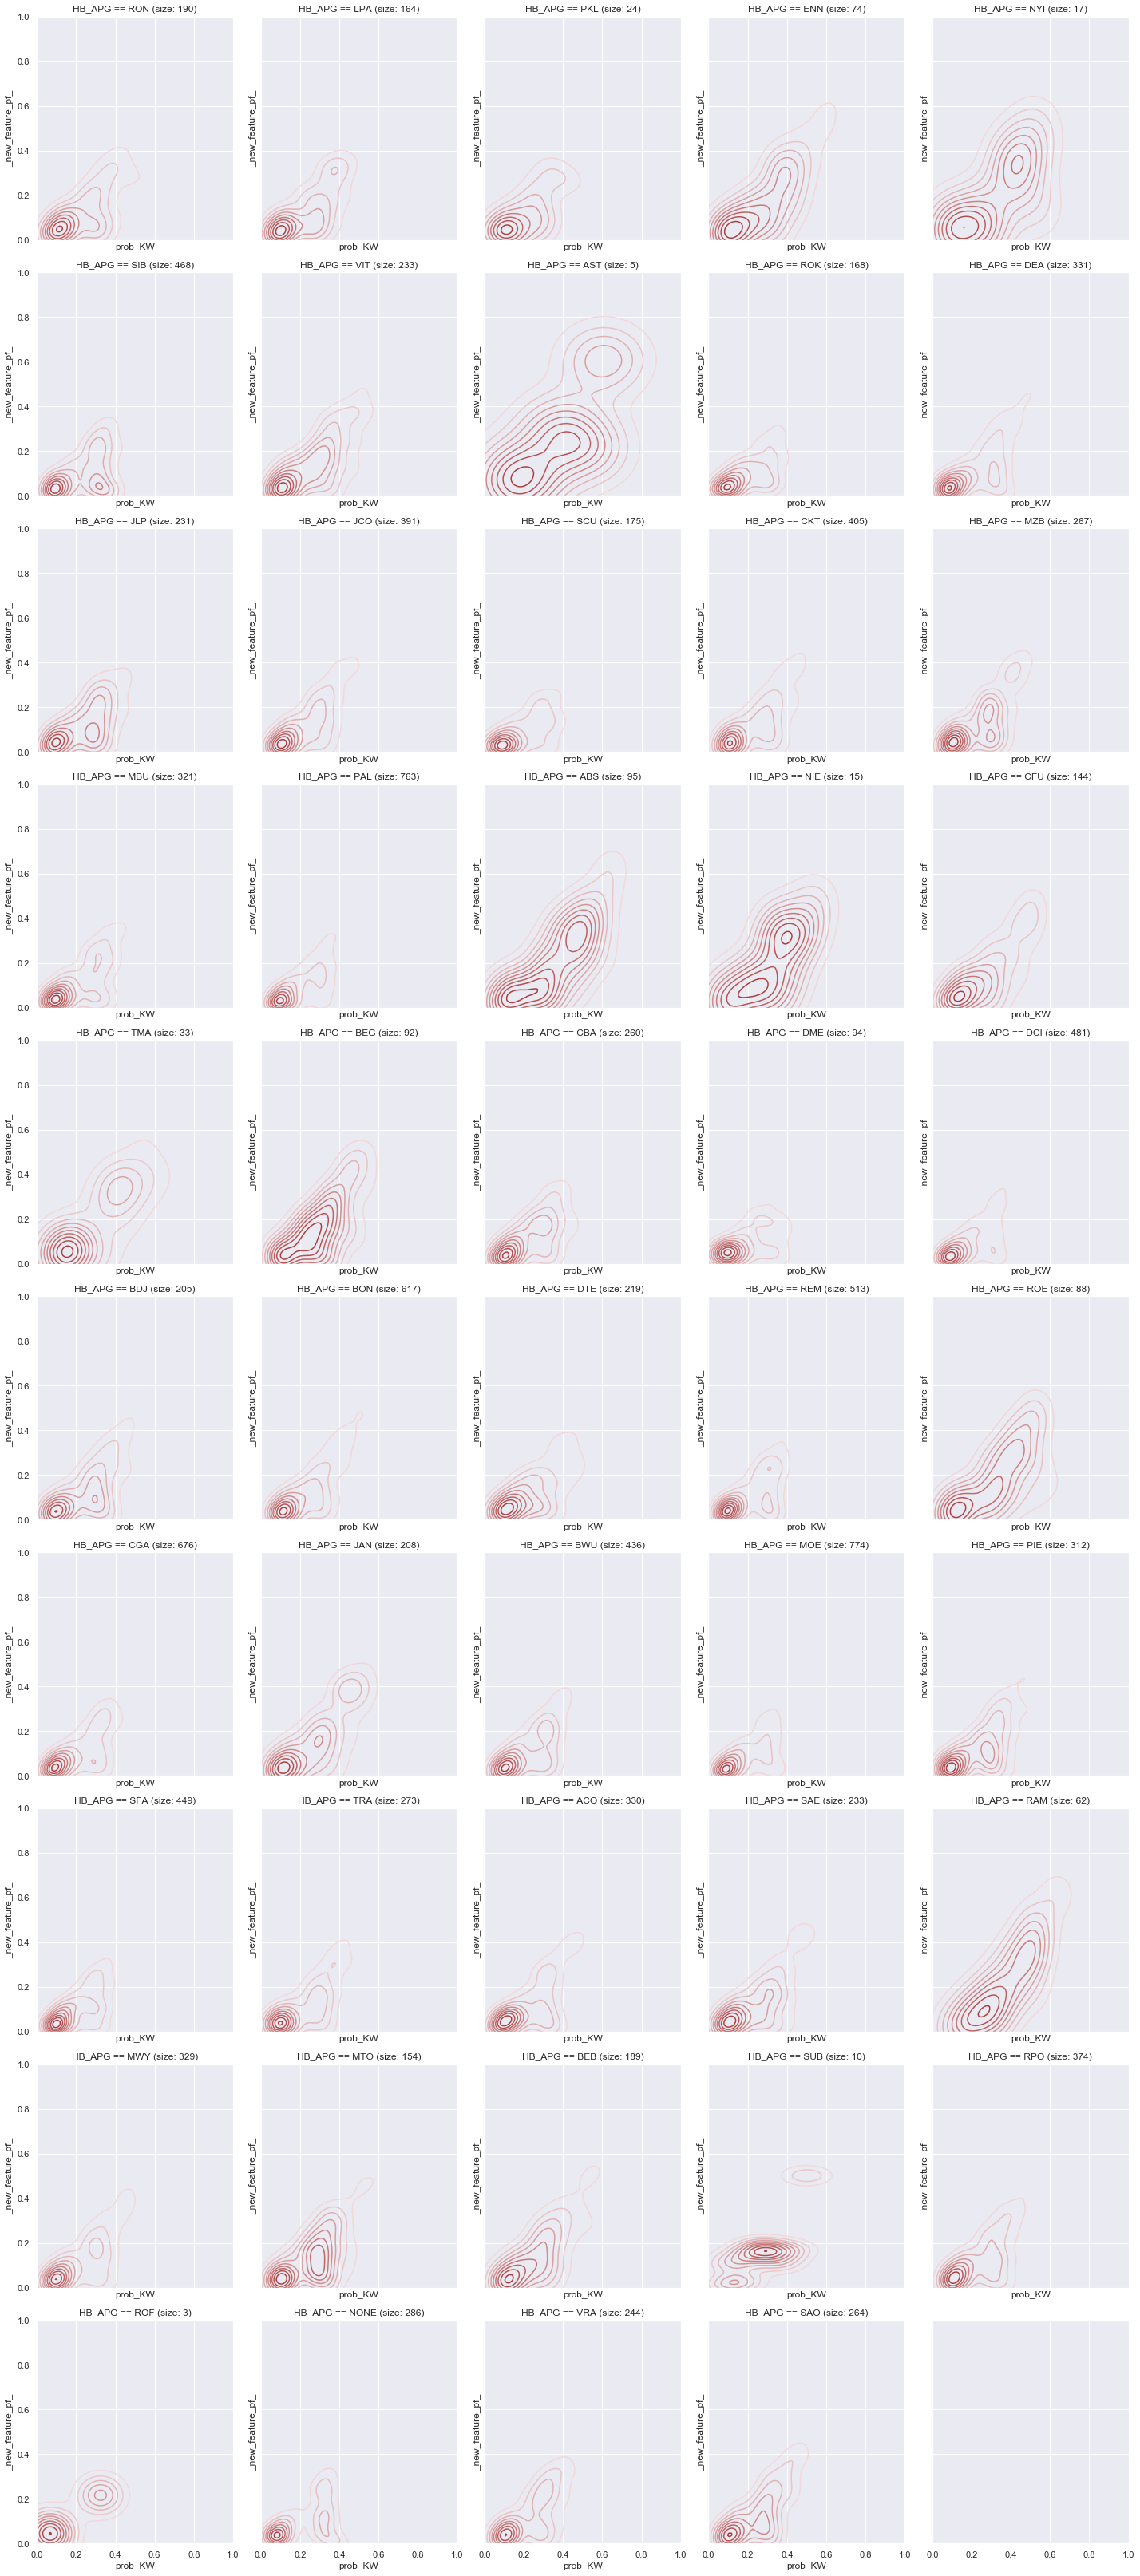

In [433]:
sns.set(style="darkgrid")

########################################################################################
# Preselect only VB's with enough leads for plotting:
_subset_ = (
    ek_list.groupby("_HB_APG_").agg({"Endkunde_NR": np.count_nonzero}).reset_index()
).rename(columns={"Endkunde_NR": "n_leads"})


_relevant_vbs_ = list(set(_subset_.loc[_subset_.n_leads > 2, "_HB_APG_"]))

########################################################################################
# Define how many subplots per row:

_n_columns_ = 5
_n_rows_ = np.ceil(len(_relevant_vbs_) / _n_columns_).astype("int64")

########################################################################################
# Set up the matplotlib figure:

f, axes = plt.subplots(
    nrows=_n_rows_, ncols=_n_columns_, figsize=(20, 45), sharex=True, sharey=True
)

########################################################################################
# Loop over subplots and assign each vb one subplot:

for (_ax_, vb) in zip(axes.flat, _relevant_vbs_):

    # Select dataset, only chosen VB:
    _subset_vb_ = ek_list.loc[ek_list._HB_APG_ == vb, :]

    _cmap_ = sns.light_palette("brown", reverse=False, as_cmap=True)

    sns.kdeplot(
        _subset_vb_.prob_KW,  # X-Axis
        _subset_vb_._new_feature_pf_, # Y-Axis
        #_subset_vb_.f_score,  # Y-Axis
        shade=False,
        ax=_ax_,
        cmap=_cmap_,
    )

    #     _ax_.hexbin(
    #         _subset_vb_.prob_KW,  # X-Axis
    #         #         #_subset_vb_._new_feature_pf_, # Y-Axis
    #         _subset_vb_.f_score,  # Y-Axis
    #         alpha=0.5,
    #         gridsize=10,
    #     )

    _ax_.set(xlim=(0, 1), ylim=(0, 1))
    _ax_.set(title=f"HB_APG == {vb} (size: {_subset_vb_.shape[0]})")

########################################################################################
# Readjust plot:

f.tight_layout()

########################################################################################
# Clean up all technical definitions:

del _subset_, _relevant_vbs_, _n_columns_, _n_rows_, _ax_, _subset_vb_, _cmap_

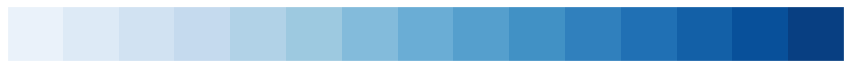

In [232]:
sns.palplot(sns.color_palette(palette='Blues',n_colors=15))

# Scribbles

In [277]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:423: UserWarning: The following kwargs were not used by contour: 'kind'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


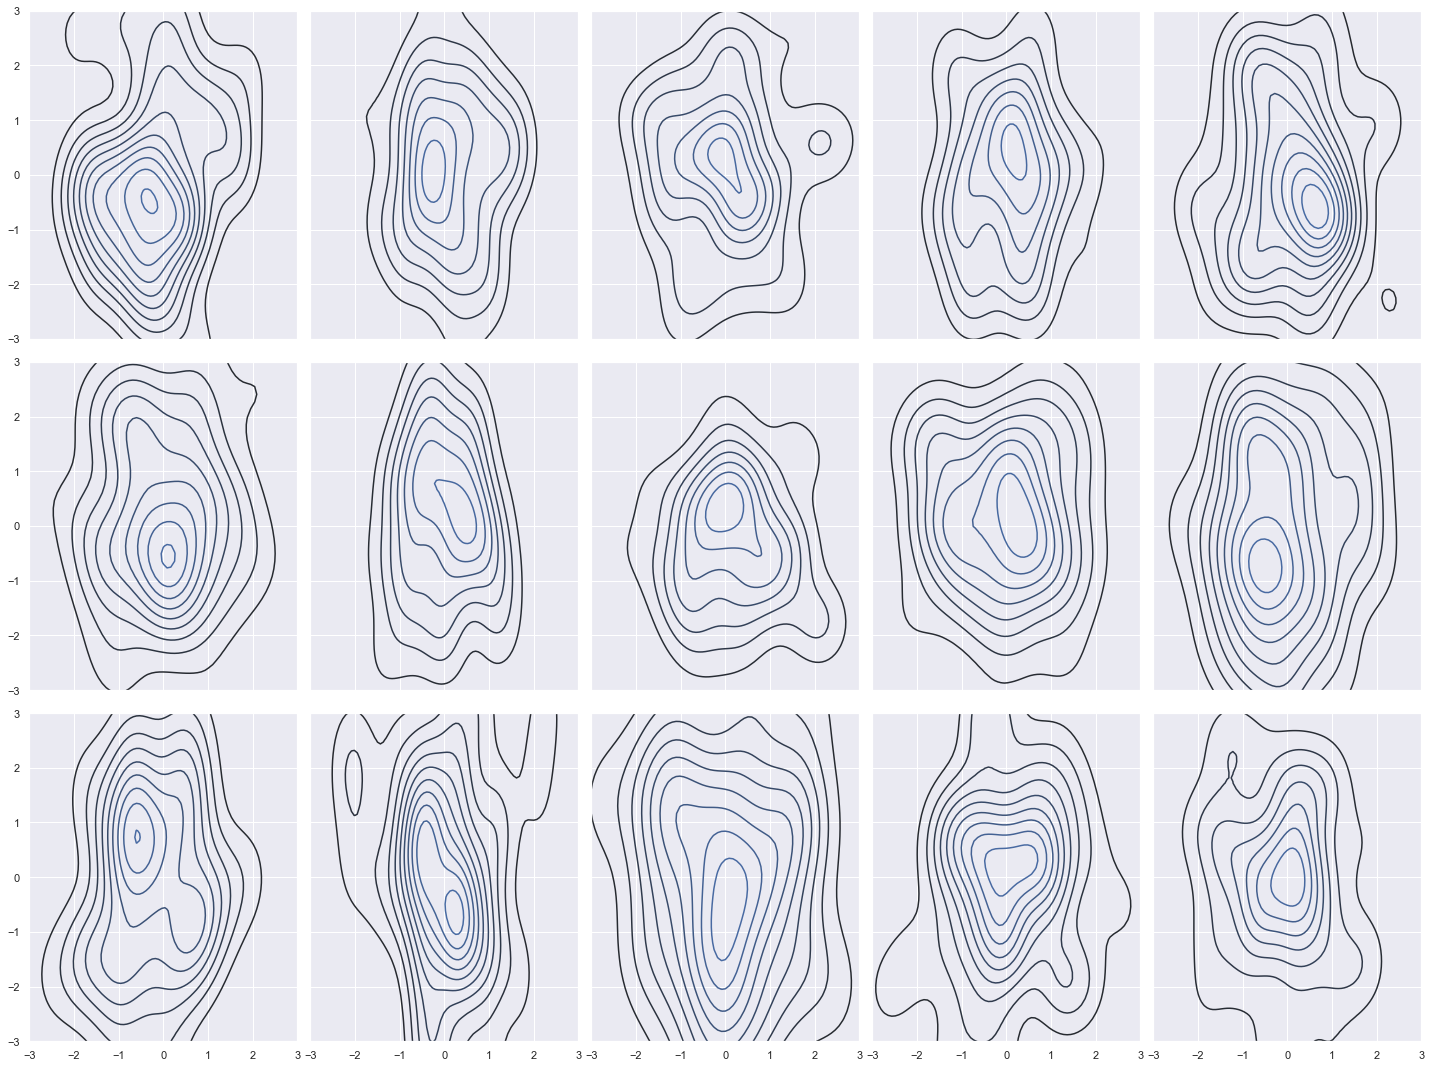

In [418]:
sns.set(style="darkgrid")
rs = np.random.RandomState(42)

# Set up the matplotlib figure
f, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 15), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle

for _ax_, s_color in zip(axes.flat, np.linspace(0, 3, axes.shape[0] * axes.shape[1])):

    # Create a cubehelix colormap to use with kdeplot
    _cmap_ = sns.cubehelix_palette(start=s_color, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset

    x = rs.randn(1, 50)[0] # random numberes
    y = np.random.normal(loc=0,scale=1.5,size=50) # normal distributed numbers

    sns.kdeplot(x, y, kind="hex",ax=_ax_)
    _ax_.set(xlim=(-3, 3), ylim=(-3, 3))

f.tight_layout()

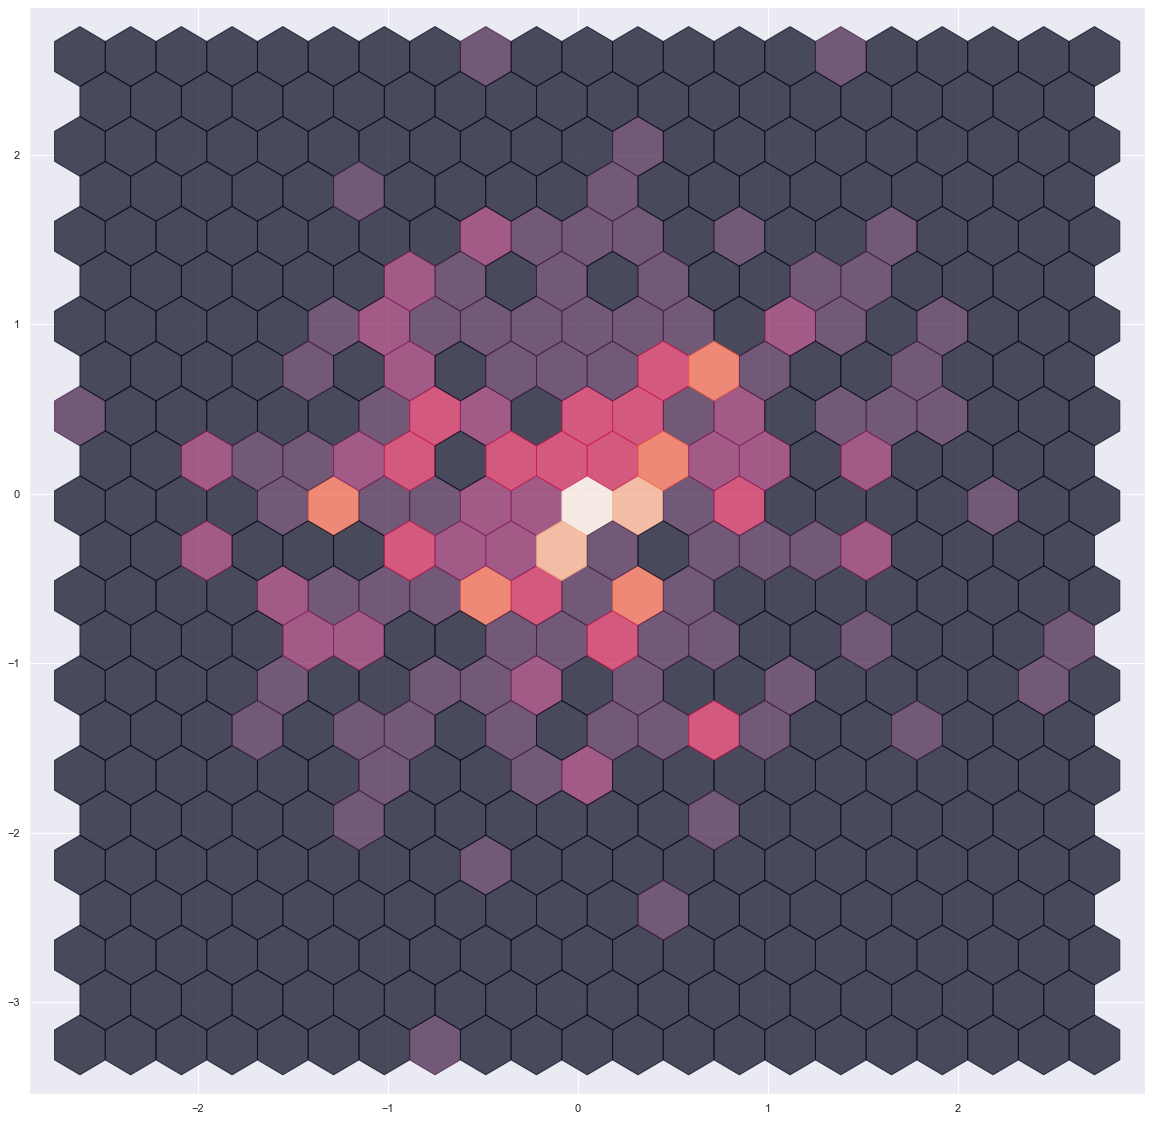

In [432]:
plt.figure(figsize=(20, 20))
x = np.random.RandomState(42).randn(1, 200)[0]
y = np.random.RandomState(529).randn(1, 200)[0]
plt.hexbin(x, y, alpha=0.7, gridsize=20)